## Task 2
### Using existing Transformer model and its fine tuning

В Hugging Face в качестве подходящей для идентификации языков с кириллицей была выбрана модель "SebOchs/canine-c-lang-id", которая умеет распознавать 223 языка, в том числе многие из входящих в датасет. По описанию качество модели следующее:

* Accuracy: 94,92%
* Macro F1-score: 94,91%

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] accelerate pycountryb

Читаем с Гугл-диска датасет. Кстати, по сравнению с предыдущим этапом он доработан, добавлены тексты для языков, где их было мало, чтобы лучше сбалансировать классы. И вместо абзацев датасет теперь разбит на предложения. 
Кроме того, сделано пребразование в формат Hugging Face

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/MyDrive/train/lid.zip

Mounted at /content/drive
Archive:  drive/MyDrive/train/lid.zip
   creating: lid/
   creating: lid/train/
  inflating: lid/train/data-00000-of-00001.arrow  
  inflating: lid/train/state.json    
  inflating: lid/train/cache-934fab53fb367c30.arrow  
  inflating: lid/train/dataset_info.json  
  inflating: lid/train/cache-c231bff8c615096d.arrow  
  inflating: lid/train/cache-a0c1297d3543dfd3.arrow  
   creating: lid/test/
  inflating: lid/test/data-00000-of-00001.arrow  
  inflating: lid/test/state.json     
  inflating: lid/test/cache-6df024453add90c3.arrow  
  inflating: lid/test/dataset_info.json  
  inflating: lid/test/cache-7a70d1f4e2e9c7fc.arrow  
  inflating: lid/test/cache-ed04687f80a001d5.arrow  
  inflating: lid/test/cache-3acb765c1f1282d9.arrow  
  inflating: lid/test/cache-9869a57e9096f4ef.arrow  
  inflating: lid/test/cache-2fb02146d694e746.arrow  
 extracting: lid/dataset_dict.json   


Код из карточки выбранной модели для создания словаря языков.
Так как для 3 языков, которые используются в моем датасете, 
названия не совпадают, добавим преобразование.

In [2]:
import pycountry
import datasets

wili = datasets.load_dataset('wili_2018')
# names for languages not in iso-639-3 from wikipedia
non_iso_languages = {'roa-tara': 'Tarantino', 'zh-yue': 'Cantonese', 'map-bms': 'Banyumasan',
                      'nds-nl': 'Dutch Low Saxon', 'be-tarask': 'Belarusian-Tarask'}

# difference in lang names in choosen model and my dataset
diff = {'Russia Buriat':'Buriat', 'Kirghiz':'Kyrgyz', 'Ossetian':'Ossetic'}

# create dictionary from data set labels to language names
lab2lang = {}
for i, lang in enumerate(wili['train'].features['label'].names):
  full_lang = pycountry.languages.get(alpha_3=lang)
  if full_lang:
    lab2lang[i] = diff.get(full_lang.name, full_lang.name)
  else:
    lab2lang[i] = non_iso_languages[lang]

Generating train split:   0%|          | 0/117500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/117500 [00:00<?, ? examples/s]

Dataset wili_2018 downloaded and prepared to /root/.cache/huggingface/datasets/wili_2018/WiLI-2018 dataset/1.1.0/78d7fe4a9d0a01168e45657f302c776ee0afc0978d44e2c3759f4c4975b845f5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Теперь созаддим датасет для оценки существующей модели. Оставим в датасете только те языки, которые знает модель. Также создадим словарь преобразования числовых меток языков.

In [3]:
from datasets import ClassLabel
ds = datasets.load_from_disk('lid')

# copy of dataset features
features = ds['train'].features.copy()
# get the ClassLabel object from existing features
class_label = features['label']
# get lang list from it, these are langs of my dataset
langs = class_label.names

# dicts for conversion from ids to labels and vice versa
id2label = {idx: langs[idx] for idx in range(len(langs))}
label2id = {v: k for k,v in id2label.items()}

# common is a list of languages from model and my dataset
common = [label2id[x] for x in langs if x in lab2lang.values()]

# create the new features for casting with new ClassLabel
features['label'] = ClassLabel(names=[lab2lang[k] for k in sorted(lab2lang)])

# mapper to convert label ids and corresponding funciton
mapper = {label2id[v]:k for k,v in lab2lang.items() if v in label2id}
def map_lang(x):
  x['label'] = mapper[x['label']]
  return x

# and finally parameters for model evaluation, we need to create new labels
n_labs = len(lab2lang)
id2lab = {i:f'LAB_{i}' for i in range(n_labs)}
lab2id = {v:k for k,v in id2lab.items()}

# create a partial dataset by filtering common langs, cast features, and map ids
ds_part = ds.filter(lambda x: x['label'] in common).cast(features).map(map_lang)

Filter:   0%|          | 0/41594 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10399 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/38276 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9568 [00:00<?, ? examples/s]

Map:   0%|          | 0/38276 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

Датасет для оценки готов, можно загружать модель и проверять, как она работает.
Токенайзер для выбранной модели выдает ошибку при загрузке, поэтому выбираем токенайзер родительской модели.

In [5]:
from transformers import CanineTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = CanineTokenizer.from_pretrained("google/canine-c", padding="longest")

model = AutoModelForSequenceClassification.from_pretrained("SebOchs/canine-c-lang-id",
                                                             num_labels=n_labs, id2label=id2lab, label2id=lab2id)

pipe = pipeline("text-classification",
                tokenizer = tokenizer,
                model = model)

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Запускаем оценку, получаем accuracy около 0.8 для нашего датасета. 

In [53]:
import evaluate

metric = evaluate.load('accuracy')
evaluator = evaluate.evaluator("text-classification")

result = evaluator.compute(model_or_pipeline=pipe, 
                           data=ds_part['test'].select(range(1000)), metric=metric, label_mapping=lab2id)

print(result)


{'accuracy': 0.794, 'total_time_in_seconds': 271.81565637399945, 'samples_per_second': 3.6789639468893194, 'latency_in_seconds': 0.27181565637399946}


Теперь начинаем процесс дообучения. Так как количество меток поменялось, нужно использовать опцию ignore_mismatched_sizes

In [6]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length')

tokenized_ds = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

n_labs = len(langs)
model = AutoModelForSequenceClassification.from_pretrained("SebOchs/canine-c-lang-id",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=n_labs, 
                                                           id2label=id2label, label2id=label2id)

Map:   0%|          | 0/41594 [00:00<?, ? examples/s]

Map:   0%|          | 0/10399 [00:00<?, ? examples/s]

Some weights of CanineForSequenceClassification were not initialized from the model checkpoint at SebOchs/canine-c-lang-id and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([235, 768]) in the checkpoint and torch.Size([36, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([235]) in the checkpoint and torch.Size([36]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Задаем аргументы для тренера и сам тренер. С данным набором аргументов памяти стало потребляться заметно меньше, и все теперь без проблем запускается в Colab на GPU. 

Для начала возьмем 3600 элементов из тренировочного набора

In [9]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    "train_out",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    optim="adafactor",
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_ds["train"].shuffle().select(range(3600)),
    eval_dataset=tokenized_ds["test"].select(range(720)),
    data_collator=data_collator,
    tokenizer=tokenizer,
)


In [10]:
trainer.train()

Step,Training Loss
500,1.757500
1000,0.992700
1500,0.689600
2000,0.546100


Step,Training Loss
500,1.757500
1000,0.992700
1500,0.689600
2000,0.546100
2500,0.365300


TrainOutput(global_step=2700, training_loss=0.8343346009431062, metrics={'train_runtime': 1625.5942, 'train_samples_per_second': 6.644, 'train_steps_per_second': 1.661, 'total_flos': 1.41910569713664e+16, 'train_loss': 0.8343346009431062, 'epoch': 3.0})

После тренировки accuracy уже 0.868, при этом модель обучена уже на датасете со всеми языками.


In [21]:
pipe = pipeline("text-classification",
                tokenizer = tokenizer,
                model = model,
                device = "cuda:0")

result = evaluator.compute(model_or_pipeline=pipe, 
                           data=ds['test'].select(range(720, 1440)), 
                           metric=metric, 
                           label_mapping=label2id)

print(result)
trainer.save_model('model')

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'accuracy': 0.8680555555555556, 'total_time_in_seconds': 27.361996188000376, 'samples_per_second': 26.313869611448762, 'latency_in_seconds': 0.038002772483333856}


Запустим тренировку еще для 10800 предложений.

In [22]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_ds["train"].shuffle().select(range(10800)),
    eval_dataset=tokenized_ds["test"].select(range(720)),
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

Step,Training Loss
500,0.737700
1000,0.759200
1500,0.657000
2000,0.699500
2500,0.602500
3000,0.487600
3500,0.495300
4000,0.401000


Step,Training Loss
500,0.737700
1000,0.759200
1500,0.657000
2000,0.699500
2500,0.602500
3000,0.487600
3500,0.495300
4000,0.401000
4500,0.370500
5000,0.405000


TrainOutput(global_step=8100, training_loss=0.44025992475909953, metrics={'train_runtime': 4768.7835, 'train_samples_per_second': 6.794, 'train_steps_per_second': 1.699, 'total_flos': 4.25731709140992e+16, 'train_loss': 0.44025992475909953, 'epoch': 3.0})

Сохраним ммдель

In [23]:
trainer.save_model('fine_tuned_model')

Проведем еще одну оценку, accuracy почти 0.9

In [24]:
pipe = pipeline("text-classification",
                tokenizer = tokenizer,
                model = model,
                device = "cuda:0")

result = evaluator.compute(model_or_pipeline=pipe, 
                           data=ds['test'].select(range(720, 1440)), 
                           metric=metric, 
                           label_mapping=label2id)

print(result)


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'accuracy': 0.8944444444444445, 'total_time_in_seconds': 16.16877361799925, 'samples_per_second': 44.53027898160986, 'latency_in_seconds': 0.022456630024998956}


С тренировкой можно пока заканчивать, посмотрим, как модель определяет язык. Первый из двух - предсказанный. второй - реальный.

In [28]:
output = trainer.predict(tokenized_ds["test"].select(range(2060,2100)))
for x in zip(map(lambda x: id2label[x],output.predictions.argmax(1)),
             map(lambda x: id2label[x],output.label_ids),
             ds['test'].select(range(2060,2100))['text']):
    print(x)

('Western Mari', 'Belarusian', 'Гурт Крама')
('Buriat', 'Buriat', 'Энэ талын хилэ хизаарта тодорхой тогтооһон байгаалиин хилэ үгы байна')
('Tuvinian', 'Tuvinian', 'Саваларның адаа чуурга хевирлиг шиш борбак ишкири литр хире')
('Kalmyk', 'Kalmyk', 'Тегәд келнә туст энд дала төр һархш')
('Belarusian', 'Belarusian', 'Творчая дзейнасць звязаная з вобразным адлюстраваннем рэчаіснасці')
('Komi', 'Komi', 'Тундраясын торъя нин Выль Му вылын да Шпицберген вылын на кид стадаяс')
('Chechen', 'Chechen', 'Коьрта импорт мехкдаьтта машенин лаьттан туьха химикаташ')
('Kyrgyz', 'Kyrgyz', 'Анда ачык жана суук абарайы үстөмдүк кылат абанын температурасынын абсолюттук минимуму Оймякондо Верхоянскиде Якутияда жетет')
('Kazakh', 'Kazakh', 'Эволюциялық өзгерістер сыртқы ортаның өзгерісіне организмдердің бейімделуімен ұштасады')
('Ossetic', 'Ossetic', 'азы сипайты сыстад моголты падишахы арвыстой ахасты')
('Russian', 'Russian', 'этом смысле искусство и вообще креативность нечто к чему человека толкает его соб

Построим матрицу ошибок

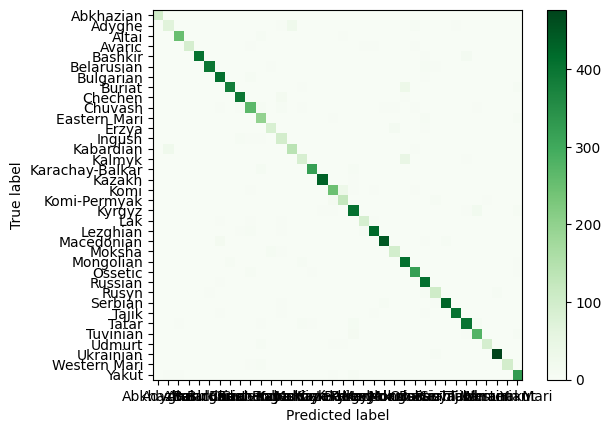

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#output = trainer.predict(tokenized_ds["test"])

y_true = list(map(lambda x: id2label[x], output.label_ids))
y_pred = list(map(lambda x: id2label[x], output.predictions.argmax(1)))

cm = confusion_matrix(y_true, y_pred, labels=langs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=langs)
disp.plot(include_values=False, cmap="Greens")
plt.show()

Еще создадим список пар, в которых модель ошиблась больше 5 раз. Видно, что по большей части это родственные языки.

In [52]:
errors = {}
for x in zip(y_true, y_pred):
  if x[0] == x[1]:
    continue
  if x in errors:
    errors[x] += 1
  else:
    errors[x] = 1
{k:v for k,v in sorted(errors.items(), key=lambda x:x[1], reverse=True) if v > 5}

{('Kalmyk', 'Mongolian'): 46,
 ('Komi', 'Komi-Permyak'): 33,
 ('Buriat', 'Mongolian'): 32,
 ('Kabardian', 'Adyghe'): 26,
 ('Adyghe', 'Kabardian'): 25,
 ('Kyrgyz', 'Tuvinian'): 18,
 ('Macedonian', 'Bulgarian'): 14,
 ('Chechen', 'Ingush'): 14,
 ('Erzya', 'Moksha'): 13,
 ('Bashkir', 'Tatar'): 12,
 ('Komi-Permyak', 'Komi'): 11,
 ('Tuvinian', 'Kyrgyz'): 11,
 ('Tatar', 'Tuvinian'): 9,
 ('Karachay-Balkar', 'Eastern Mari'): 8,
 ('Moksha', 'Erzya'): 8,
 ('Tatar', 'Kyrgyz'): 8,
 ('Ossetic', 'Chuvash'): 7,
 ('Karachay-Balkar', 'Kyrgyz'): 7,
 ('Lezghian', 'Lak'): 7,
 ('Ingush', 'Chechen'): 6,
 ('Rusyn', 'Russian'): 6,
 ('Rusyn', 'Ukrainian'): 6,
 ('Buriat', 'Yakut'): 6}

Ну и напишем функцию для предсказания отдельного предложения.

In [26]:
def infer(s):
    out = trainer.predict([tokenize_function({'text': s})])
    print(id2label[out.predictions.argmax(1)[0]])

In [27]:
infer("Мин уҡыусы түгелмен.")

Bashkir
